# Introducing Keras

Be sure to be using tensorflow 1.9 or newer!

Keras is a higher-level API within TensorFlow that makes things a lot easier. Not only is it easier to use, it's easier to tune.

Let's set up the same deep neural network we set up with TensorFlow to learn from the MNIST data set.

First we'll import all the stuff we need, which will initialize Keras as a side effect:

In [130]:
from tensorflow import keras

# from tensorflow.keras.datasets import mnist
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import RMSprop

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, SGD, Adagrad

We'll load up the MNIST data set. Again, there are 60K training samples and 10K test samples.

In [131]:
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()
# print(mnist_train_labels)
# print(mnist_train_images[0])
# print(mnist_train_labels[0])
# print(len(mnist_train_images[0]))
# print(len(mnist_train_images[0][0]))

We need to explicitly convert the data into the format Keras / TensorFlow expects. We divide the image data by 255 in order to normalize it into 0-1 range, after converting it into floating point values.

In [132]:
train_images = mnist_train_images.reshape(60000, 784)
test_images = mnist_test_images.reshape(10000, 784)
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

# print(train_images[0])
print(len(train_images))
print(len(train_images[0]))
print(train_images[0][783])

60000
784
0.0


Now we'll convert the 0-9 labels into "one-hot" format. Think of one_hot as a binary representation of the label data - that is, which number each handwriting sample was intended to represent. Mathematically one_hot represents a dimension for every possible label value. Every dimension is set to the value 0, except for the "correct" one which is set to 1. For example, the label vector representing the number 1 would be [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] (remember we start counting at 0.) It's just a format that's optimized for how the labels are applied during training.

So the training label data is a tensor of shape [60,000, 10] - 60,000 test images each associated with 10 binary values that indicate whether or not the image represents a given number from 0-9.

In [133]:
train_labels = keras.utils.to_categorical(mnist_train_labels, 10)
test_labels = keras.utils.to_categorical(mnist_test_labels, 10)
print(len(train_labels))
print(len(train_labels[0]))
print(train_labels[0])
print(mnist_train_labels[0])

60000
10
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5


Let's take a peek at one of the training images just to make sure it looks OK:

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


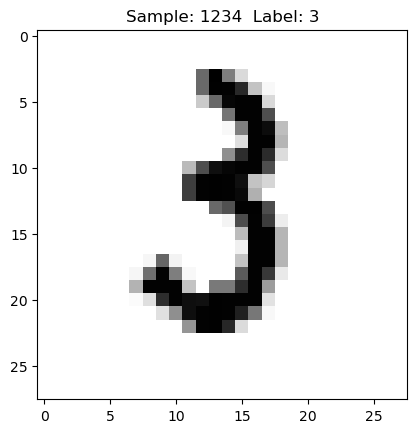

In [134]:
import matplotlib.pyplot as plt

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number
    label = train_labels[num].argmax(axis=0)
    #Reshape the 768 values to a 28x28 image
    image = train_images[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(1234)

Here's where things get exciting. All that code we wrote in Tensorflow creating placeholders, variables, and defining a bunch of linear algebra for each layer in our neural network? None of that is necessary with Keras!

We can set up the same layers like this. The input layer of 784 features feeds into a ReLU layer of 512 nodes, which then goes into 10 nodes with softmax applied. Couldn't be simpler:

In [135]:
# model = Sequential()
# model.add(Dense(512, activation='relu', input_shape=(784,)))
# model.add(Dense(10, activation='softmax'))

In [136]:
model = Sequential()
model.add(Input(shape=(784,)))
# model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

We can even get a nice description of the resulting model:

In [137]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

Setting up our optimizer and loss function is just as simple. We will use the RMSProp optimizer here. Other choices include Adagrad, SGD, Adam, Adamax, and Nadam. See https://keras.io/optimizers/

In [138]:
model.compile(loss='categorical_crossentropy',
              # optimizer=RMSprop(),
              optimizer=SGD(),
              # optimizer=Adagrad(),
              metrics=['accuracy'])

Training our model is also just one line of code with Keras. Here we'll do 10 epochs with a batch size of 100. Keras is slower, and if we're not running on top of a GPU-accelerated Tensorflow this can take a fair amount of time (that's why I've limited it to just 10 epochs.)

In [139]:
history = model.fit(train_images, train_labels,
                    batch_size=100,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Epoch 1/10
600/600 - 3s - 4ms/step - accuracy: 0.7083 - loss: 1.1115 - val_accuracy: 0.8750 - val_loss: 0.4861
Epoch 2/10
600/600 - 2s - 4ms/step - accuracy: 0.8606 - loss: 0.4886 - val_accuracy: 0.9038 - val_loss: 0.3493
Epoch 3/10
600/600 - 2s - 4ms/step - accuracy: 0.8865 - loss: 0.3936 - val_accuracy: 0.9142 - val_loss: 0.3049
Epoch 4/10
600/600 - 2s - 3ms/step - accuracy: 0.8986 - loss: 0.3487 - val_accuracy: 0.9238 - val_loss: 0.2741
Epoch 5/10
600/600 - 2s - 4ms/step - accuracy: 0.9081 - loss: 0.3201 - val_accuracy: 0.9270 - val_loss: 0.2557
Epoch 6/10
600/600 - 2s - 4ms/step - accuracy: 0.9146 - loss: 0.2950 - val_accuracy: 0.9327 - val_loss: 0.2379
Epoch 7/10
600/600 - 2s - 4ms/step - accuracy: 0.9203 - loss: 0.2755 - val_accuracy: 0.9369 - val_loss: 0.2232
Epoch 8/10
600/600 - 2s - 4ms/step - accuracy: 0.9255 - loss: 0.2579 - val_accuracy: 0.9410 - val_loss: 0.2092
Epoch 9/10
600/600 - 2s - 3ms/step - accuracy: 0.9299 - loss: 0.2435 - val_accuracy: 0.9417 - val_loss: 0.2005
E

But, even with just 10 epochs, we've outperformed our Tensorflow version considerably!

In [140]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1893594115972519
Test accuracy: 0.9442999958992004


As before let's visualize the ones it got wrong. As this model is much better, we'll have to search deeper to find mistakes to look at.

In [141]:
# print(test_images[0,:])
# print(test_images[0])
failures = 0
for x in range(1000):
    test_image = test_images[x,:].reshape(1,784)
    predicted_cat = model.predict(test_image).argmax()
    label = test_labels[x].argmax()
    if (predicted_cat != label):
        failures = failures + 1
        # plt.title('Prediction: %d Label: %d' % (predicted_cat, label))
        # plt.imshow(test_image.reshape([28,28]), cmap=plt.get_cmap('gray_r'))
        # plt.show()

print(failures)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

You can see most of the ones it's having trouble with, are images a human would have trouble with as well!

## Excercise

As before, see if you can improve on the results! Does running more epochs help considerably? How about trying different optimizers?

You can also take advantage of Keras's ease of use to try different topologies quickly. Keras includes a MNIST example, where they add an additional layer, and use Dropout at each step to prevent overfitting, like this:

`
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
`

Try adapting that to our code above and see if it makes a difference or not.